In [1]:
import sys

print(sys.version)

3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]


In [2]:
import os

print(os.getcwd())


C:\Users\gauta\Downloads\mask_rcnn_polygon


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "C:/Users/gauta/Downloads/mask_rcnn_polygon"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "C:/Users/gauta/Downloads/mask_rcnn_polygon/logs/object20230410T1341/mask_rcnn_object_0004.h5"

Using TensorFlow backend.


In [4]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 14 # Background + phone,laptop and mobile

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 50

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [5]:
config = CustomConfig()
CUSTOM_DIR = os.path.join(ROOT_DIR, "/dataset/")
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. 
        self.add_class("object", 1, "0")
        self.add_class("object", 2, "1")
        self.add_class("object", 3, "2")
        self.add_class("object", 4, "3")
        self.add_class("object", 5, "4")
        self.add_class("object", 6, "5")
        self.add_class("object", 7, "7")
        self.add_class("object", 8, "9")
        self.add_class("object", 9, "B")
        self.add_class("object", 10, "N")
        self.add_class("object", 11, "/")
        self.add_class("object", 12, ".")
        self.add_class("object", 13, "R")
        self.add_class("object", 14, "S")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open('C:/Users/gauta/Downloads/mask_rcnn_polygon/dataset/train/DEMO_polygons.json'))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            #name_dict = {"laptop": 1,"tab": 2,"phone": 3}
            name_dict = {"0": 1,"1": 2,"2": 3,"3": 4,"4": 5,"5": 6,"7": 7,"9": 8,"B": 9,"N": 10,"/": 11,".": 12,"R": 13,"s": 14} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "C:/Users/gauta/Downloads/mask_rcnn_polygon/dataset"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "C:/Users/gauta/Downloads/mask_rcnn_polygon/dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['B', '5', '2', '7', '3', '0', '9', 'N', '0', '2', '/', '1', '2', '/', '2', '1', '0', '2', '/', '1', '1', '/', '2', '4', 'R', 's', '.', '2', '9', '9', '.', '0', '0']
numids [9, 6, 3, 7, 4, 1, 8, 10, 1, 3, 11, 2, 3, 11, 3, 2, 1, 3, 11, 2, 2, 11, 3, 5, 13, 14, 12, 3, 8, 8, 12, 1, 1]
objects: ['B', '5', '2', '7', '3', '0', '9', 'N', '0', '2', '/', '1', '2', '/', '2', '1', '0', '2', '/', '1', '1', '/', '2', '4', 'R', 's', '.', '2', '9', '9', '.', '0', '0']
numids [9, 6, 3, 7, 4, 1, 8, 10, 1, 3, 11, 2, 3, 11, 3, 2, 1, 3, 11, 2, 2, 11, 3, 5, 13, 14, 12, 3, 8, 8, 12, 1, 1]
objects: ['B', '5', '2', '7', '3', '0', '9', 'N', '0', '2', '/', '1', '2', '/', '2', '1', '0', '2', '/', '1', '1', '/', '2', '4', 'R', 's', '.', '2', '9', '9', '.', '0', '0']
numids [9, 6, 3, 7, 4, 1, 8, 10, 1, 3, 11, 2, 3, 11, 3, 2, 1, 3, 11, 2, 2, 11, 3, 5, 13, 14, 12, 3, 8, 8, 12, 1, 1]
objects: ['B', '5', '2', '7', '3', '0', '9', 'N', '0', '2', '/', '1', '2', '/', '2', '1', '0', '2', '/', '1', '1', '/', '2', '4

In [8]:
config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [9]:
# load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:/Users/gauta/Downloads/mask_rcnn_polygon/logs/object20230410T1341/mask_rcnn_object_0004.h5






Re-starting from epoch 4


In [10]:
#Now, we are ready for testing our model on any image.

#RUN DETECTION
image_id = random.choice(dataset.image_ids)
#image_id = 'C:/Users/gauta/Downloads/mask_rcnn_polygon/Inspection20112021_113637259.bmp'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image id is : 11
image ID: object.Inspection02122021_1603486.bmp (11) C:/Users/gauta/Downloads/mask_rcnn_polygon/dataset\val\Inspection02122021_1603486.bmp
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  227.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


1
Processing 1 images
image                    shape: (348, 701, 3)         min:   14.00000  max:  230.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  125.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


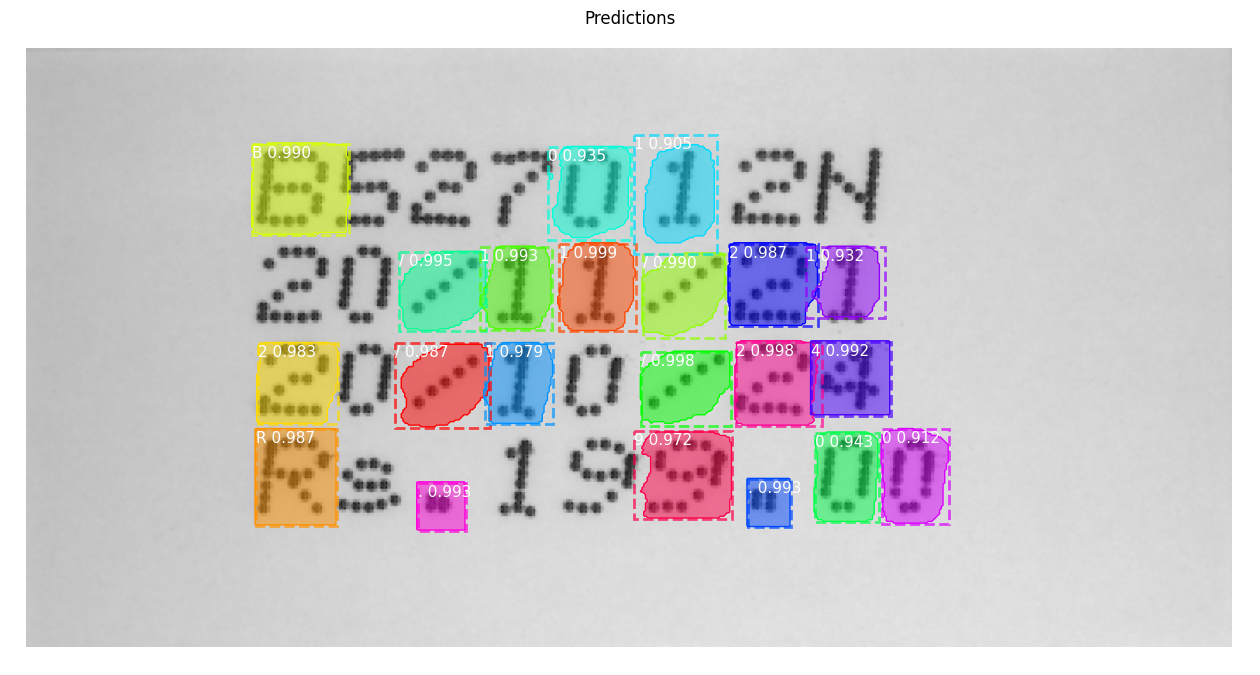

In [11]:
path_to_new_image = 'C:/Users/gauta/Downloads/mask_rcnn_polygon/Inspection20112021_113637259.bmp'
image = mpimg.imread(path_to_new_image)

# Run object detection
print(len([image]))
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
dataset.class_names, r['scores'], ax=ax, title="Predictions")

gt_class_id              shape: (33,)                 min:    1.00000  max:   14.00000  int32
gt_bbox                  shape: (33, 4)               min:  117.00000  max:  758.00000  int32
gt_mask                  shape: (1024, 1024, 33)      min:    0.00000  max:    1.00000  uint8
Predicted classes:  21R9/2.N122.19//2/1240907BS000532
[[488 558 559 627]
 [414 329 481 391]
 [551 118 628 192]
 [549 401 624 479]
 [493 476 546 550]
 [413 557 480 626]
 [588 266 625 304]
 [332 622 410 707]
 [485 405 555 468]
 [412 408 480 480]
 [489 186 555 256]
 [583 565 627 608]
 [483 332 551 392]
 [552 484 621 554]
 [419 259 481 324]
 [493 254 552 325]
 [413 186 483 261]
 [419 486 480 551]
 [413 628 481 695]
 [552 330 625 402]
 [481 623 553 697]
 [548 697 621 756]
 [333 558 407 624]
 [553 625 625 688]
 [336 334 414 400]
 [335 120 407 189]
 [570 188 626 256]
 [337 479 410 545]
 [414 117 486 180]
 [488 118 552 181]
 [333 186 409 257]
 [335 405 411 478]
 [339 257 405 327]]
Object 1 is in ROI [488 558 559 627]

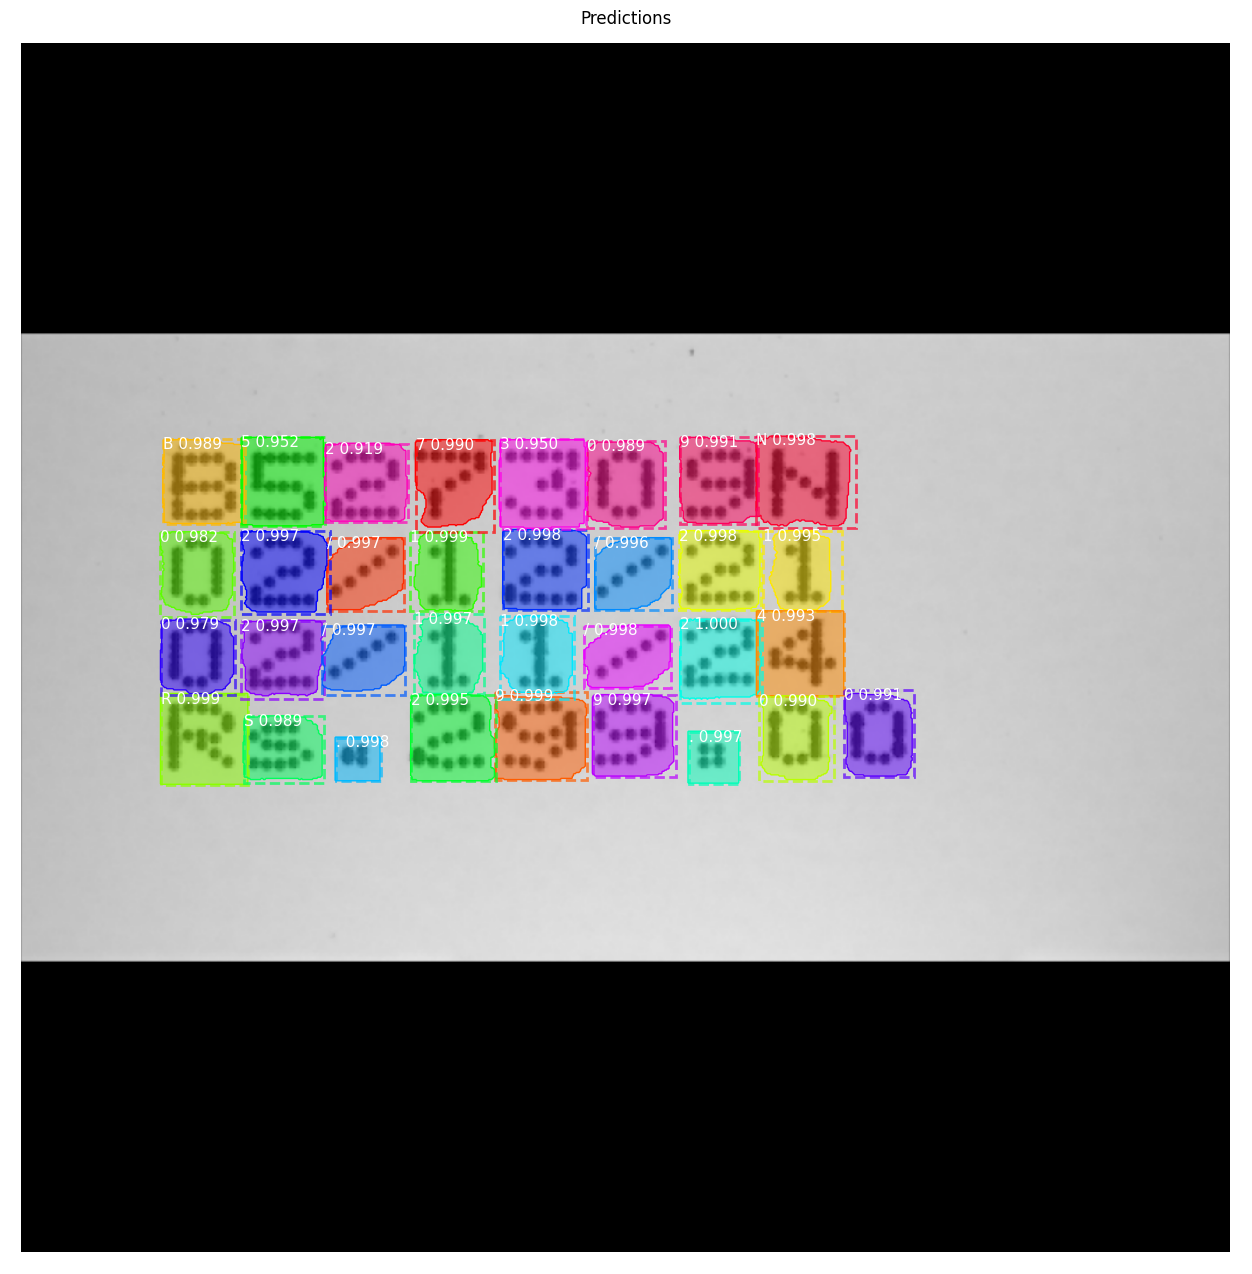

In [53]:
# Display results
x = get_ax(1)
r = results[0]
ax = plt.gca()
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=ax, title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
class_names = dataset.class_names
predicted_classes = [class_names[class_id] for class_id in r['class_ids']]
predicted_classes_str = ''.join(predicted_classes)
print('Predicted classes: ', predicted_classes_str)
print(r['rois'])
for i, roi in enumerate(r['rois']):
    class_id = r['class_ids'][i]
    class_name = dataset.class_names[class_id]
    print("Object {} is in ROI {}: {}".format(i+1, roi, class_name))


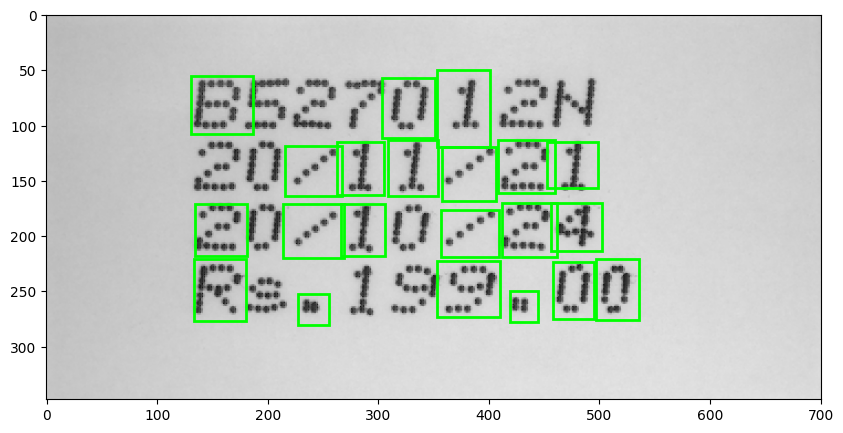

In [77]:
#FOR CUSTOM IMAGE
path_to_new_image = 'C:/Users/gauta/Downloads/mask_rcnn_polygon/Inspection20112021_113637259.bmp'
image = mpimg.imread(path_to_new_image)
results = model.detect([image], verbose=0)
# Get the ROIs for the selected image from the results object
r = results[0]
rois = r['rois']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a green bounding box around each ROI
for roi in rois:
    y1, x1, y2, x2 = roi
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()


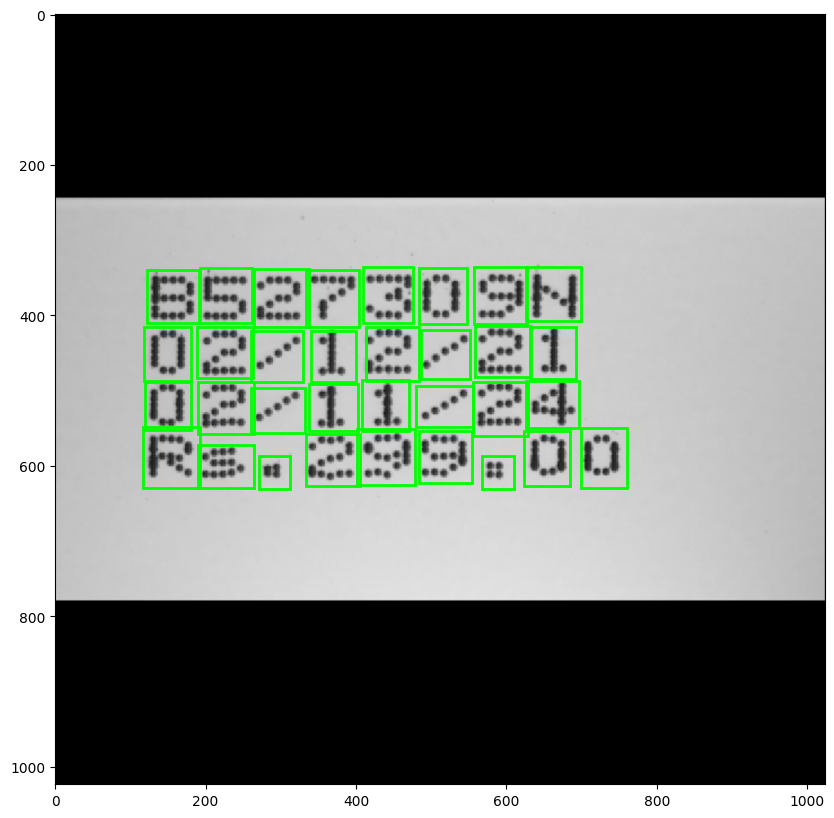

In [80]:
# Load the image using the dataset object
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)
# Get the ROIs for the selected image from the results object
r = results[0]
rois = r['rois']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a green bounding box around each ROI
for roi in rois:
    y1, x1, y2, x2 = roi
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()


In [133]:
for i, roi in enumerate(r['rois']):
    class_id = r['class_ids'][i]
    class_name = dataset.class_names[class_id]
    print("Object {} is in ROI {}: {}".format(i+1, roi, class_name))



Object 1 is in ROI [551 401 626 479]: 9
Object 2 is in ROI [415 413 487 484]: 2
Object 3 is in ROI [494 480 549 555]: /
Object 4 is in ROI [488 555 561 629]: 2
Object 5 is in ROI [336 626 408 699]: N
Object 6 is in ROI [415 632 484 693]: 1
Object 7 is in ROI [486 408 554 471]: 1
Object 8 is in ROI [421 340 488 400]: 1
Object 9 is in ROI [489 190 558 265]: 2
Object 10 is in ROI [415 188 483 263]: 2
Object 11 is in ROI [554 484 623 554]: 9
Object 12 is in ROI [420 486 485 552]: /
Object 13 is in ROI [421 261 489 330]: /
Object 14 is in ROI [487 626 550 697]: 4
Object 15 is in ROI [339 122 410 191]: B
Object 16 is in ROI [587 567 631 610]: .
Object 17 is in ROI [497 260 556 332]: /
Object 18 is in ROI [549 117 629 192]: R
Object 19 is in ROI [554 624 627 684]: 0
Object 20 is in ROI [550 699 630 760]: 0
Object 21 is in ROI [414 558 482 633]: 2
Object 22 is in ROI [416 118 487 180]: 0
Object 23 is in ROI [335 557 411 628]: 9
Object 24 is in ROI [489 119 553 180]: 0
Object 25 is in ROI [587 

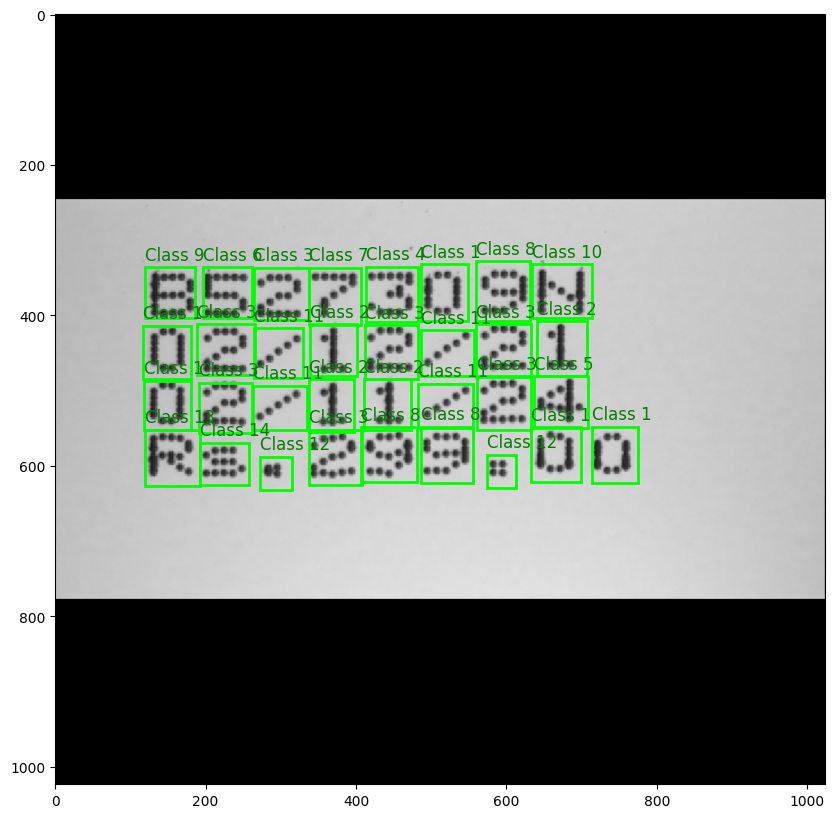

In [66]:
# Load the image using the dataset object
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)
# Get the ROIs for the selected image from the results object
r = results[0]
rois = r['rois']
class_ids = r['class_ids']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a green bounding box around each ROI and add the class ID above it
for i, roi in enumerate(rois):
    y1, x1, y2, x2 = roi
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)
    class_id = class_ids[i]
    ax.text(x1, y1-10, f'Class {class_id}', color='green', fontsize=12)

# Show the plot
plt.show()


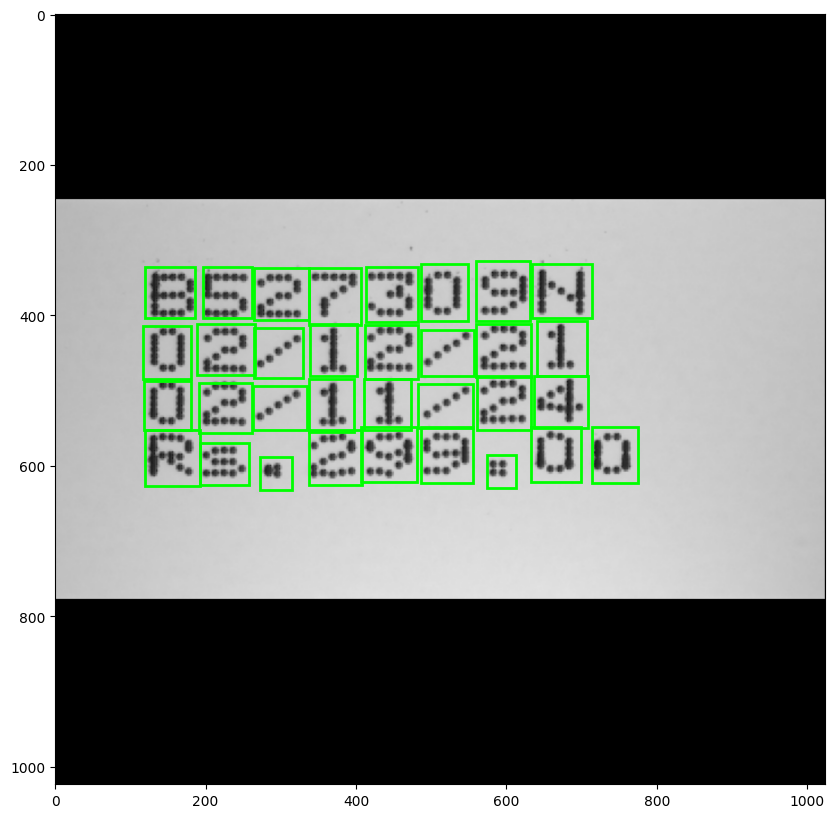

In [67]:
# Load the image using the dataset object
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)
# Get the ROIs and class IDs for the selected image from the results object
r = results[0]
rois = r['rois']
class_ids = r['class_ids']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a green bounding box around each ROI
for i, roi in enumerate(rois):
    y1, x1, y2, x2 = roi
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)
# Show the plot
plt.show()



Image shape: (189, 273, 3)
Image shape: (189, 273, 3)


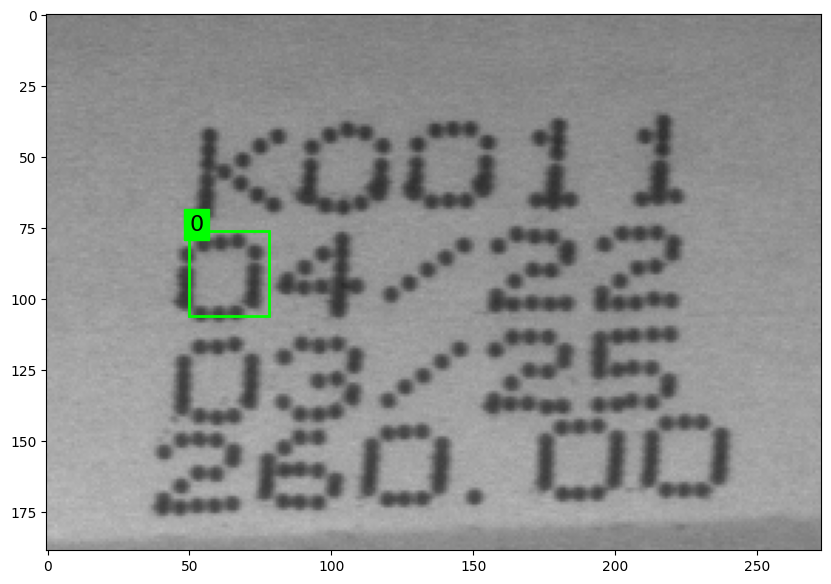

In [49]:
path_to_new_image = 'C:/Users/gauta/Downloads/mask_rcnn_polygon/Inspection02092022_16374263.bmp'
image = mpimg.imread(path_to_new_image)
print(f"Image shape: {image.shape}")
image = image[:, :, :3]
# Run object detection
results = model.detect([image], verbose=0)
# Get the ROIs and class ids for the selected image from the results object
r = results[0]
rois = r['rois']
class_ids = r['class_ids']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)
print(f"Image shape: {image.shape}")

# Draw a green bounding box and write class name above each ROI
for i, roi in enumerate(rois):
    y1, x1, y2, x2 = roi
    class_name = dataset.class_names[class_ids[i]]
    label = f"{class_name}"
    ax.text(x1, y1, label, color='k', size=16,backgroundcolor=(0,1,0))
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()


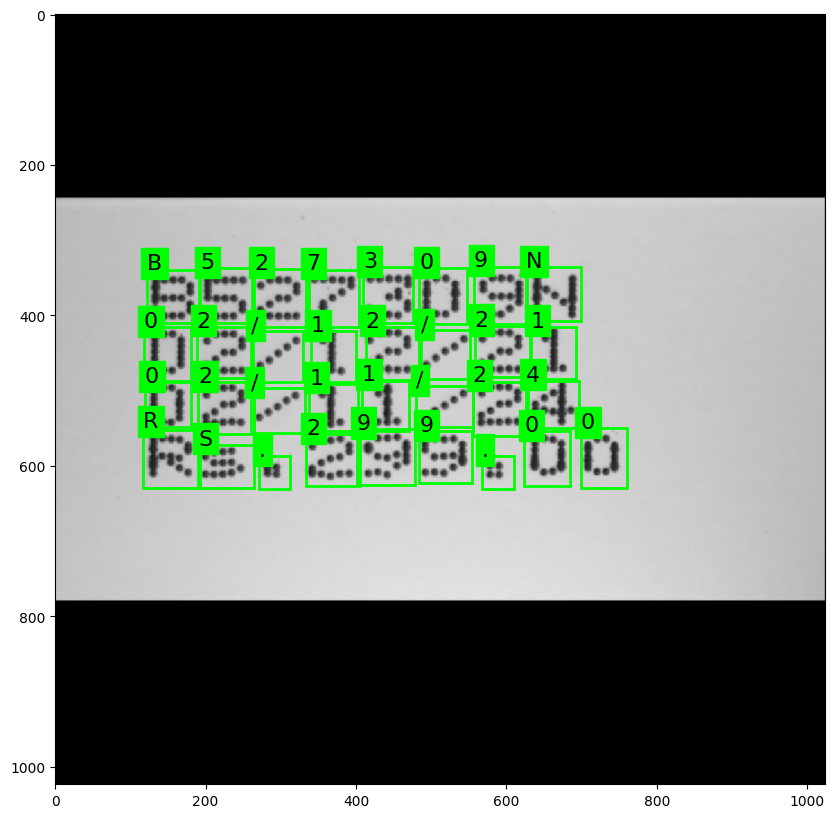

In [81]:
# Load the image using the dataset object
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)
# Get the ROIs and class ids for the selected image from the results object
r = results[0]
rois = r['rois']
class_ids = r['class_ids']

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a green bounding box and write class name above each ROI
for i, roi in enumerate(rois):
    y1, x1, y2, x2 = roi
    class_name = dataset.class_names[class_ids[i]]
    label = f"{class_name}"
    ax.text(x1, y1, label, color='k', size=16,backgroundcolor=(0,1,0))
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=(0, 1 , 0), facecolor='none')
    ax.add_patch(rect)

# Show the plot
plt.show()


In [150]:
# Create a dictionary of ROI indices and predicted class IDs
roi_dict = {}
for i, roi in enumerate(rois):
    class_id = r['class_ids'][i]
    roi_dict[i] = class_id

# Sort the dictionary by the keys
roi_dict = dict(sorted(roi_dict.items()))

# Iterate through the sorted dictionary and print the ROI index and predicted class ID
for roi_index, class_id in roi_dict.items():
    print(f"ROI {roi_index}: {class_id}")
for i, roi in enumerate(r['rois']):
    class_id = r['class_ids'][i]
    class_name = dataset.class_names[class_id]
    print("Object {} is in ROI {}: {}".format(i+1, roi, class_name))


ROI 0: 8
ROI 1: 3
ROI 2: 11
ROI 3: 3
ROI 4: 10
ROI 5: 2
ROI 6: 2
ROI 7: 2
ROI 8: 3
ROI 9: 3
ROI 10: 8
ROI 11: 11
ROI 12: 11
ROI 13: 5
ROI 14: 9
ROI 15: 12
ROI 16: 11
ROI 17: 13
ROI 18: 1
ROI 19: 1
ROI 20: 3
ROI 21: 1
ROI 22: 8
ROI 23: 1
ROI 24: 12
ROI 25: 3
ROI 26: 7
ROI 27: 1
ROI 28: 2
ROI 29: 3
ROI 30: 6
ROI 31: 14
ROI 32: 4
Object 1 is in ROI [551 401 626 479]: 9
Object 2 is in ROI [415 413 487 484]: 2
Object 3 is in ROI [494 480 549 555]: /
Object 4 is in ROI [488 555 561 629]: 2
Object 5 is in ROI [336 626 408 699]: N
Object 6 is in ROI [415 632 484 693]: 1
Object 7 is in ROI [486 408 554 471]: 1
Object 8 is in ROI [421 340 488 400]: 1
Object 9 is in ROI [489 190 558 265]: 2
Object 10 is in ROI [415 188 483 263]: 2
Object 11 is in ROI [554 484 623 554]: 9
Object 12 is in ROI [420 486 485 552]: /
Object 13 is in ROI [421 261 489 330]: /
Object 14 is in ROI [487 626 550 697]: 4
Object 15 is in ROI [339 122 410 191]: B
Object 16 is in ROI [587 567 631 610]: .
Object 17 is in ROI [497

Predicted classes:  21R9/2.N122.19//2/1240907BS000532


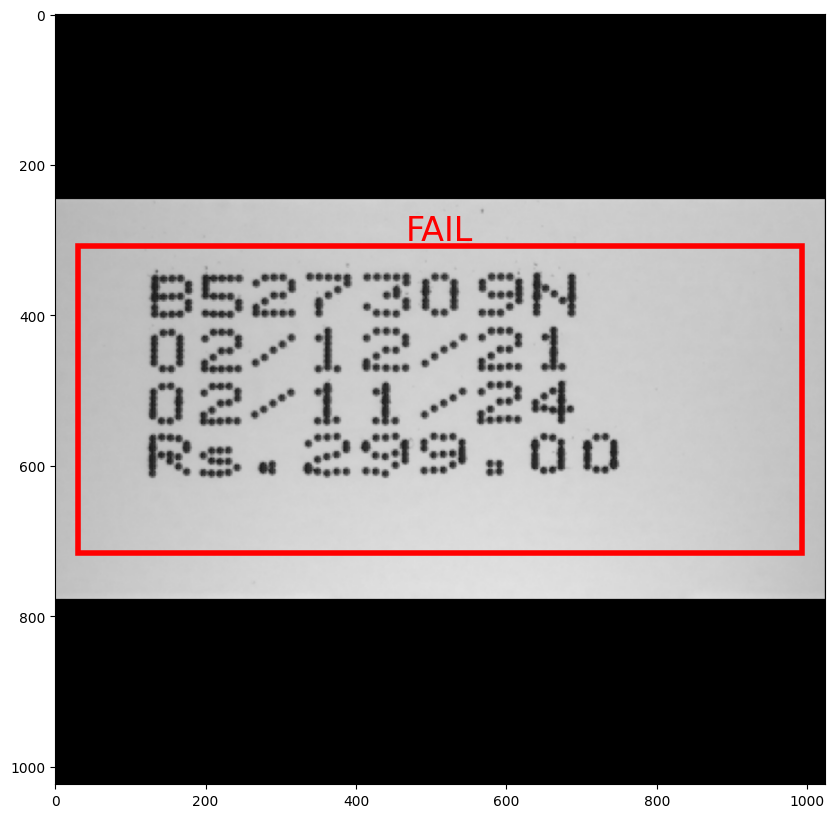

In [54]:
# Load the image using the dataset object
image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=0)

# Get the predicted classes as a string
predicted_classes = [class_names[class_id] for class_id in results[0]['class_ids']]
predicted_classes_str = ''.join(predicted_classes)
print('Predicted classes: ', predicted_classes_str)
input_string=("2/2N111229//4B./R002090.270125S3")


# Define the coordinates of the bounding box
height, width, _ = image.shape

# Define the coordinates of the bounding box
x1 = int(0.03 * width)  
y1 = int(0.3 * height)  
x2 = int(0.97 * width)  
y2 = int(0.7 * height)  
# Define the text to be displayed above the bounding box
if predicted_classes_str == input_string:
    text = 'PASS'
    bbox_color = (0, 1, 0)  # Green color
else:
    text = 'FAIL'
    bbox_color = (1, 0, 0)  # Red color

# Create a figure and axes
fig, ax = plt.subplots(1, figsize=(10, 10))

# Display the image
ax.imshow(image)

# Draw a bounding box around the region of interest
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=4, edgecolor=bbox_color, facecolor='none')
ax.add_patch(rect)

# Add the text above the bounding box
ax.text((x1 + x2) / 2, y1 - 20, text, fontsize=24, color=bbox_color, ha='center', va='center')

# Show the plot
plt.show()
